# Forage - PwC Switzerland Digital Intelligence Virtual Case Experience

#### Task 2: Responsible AI - Understanding how AI leads to better decisions.

## Task

- Create a classification model in Python. Feel free to use libraries such as SkLearn, Keras/Tensorflow or Pytorch. 
- Analyse the model and provide insight into which features/variables influence the outcome of the classification the most: on a global level, and specifically for observation #4 and #20
- Develop some form of plot or graph with brief comments on your observations. 

## Approach

#### Data
- Quick understanding of the dataset
- Remove null values etc. 

#### Modeling
- Build classification model - CatBoost

#### XAI - SHAP
- Global level: Feature importance 
- Observation level: #4 & #20


### Import packages

In [1]:
#!pip install catboost
#!pip install shap

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split

import catboost as cb
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_fscore_support as score
import shap
shap.initjs()

### Load dataset

In [3]:
# data from Kaggle: https://www.kaggle.com/henriqueyamahata/bank-marketing

In [4]:
bank_data =pd.read_csv('bank-additional-full.csv', header = 0, sep = ';' )

### Data - Review/explore

In [5]:
# head review of the dataset
# there are "unknown" valuea (see index 7) which will be assumed == Nan
bank_data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# drop col "duration". Since the duration of the call to a customer affect the output, and a value that is recorded in the data after the action, its removed. 

"""
Duration: last contact duration, in seconds (numeric). Important note:  
this attribute highly affects the output target (e.g., if duration=0 then y="no"). 
Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. 
Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to 
have a realistic predictive model.
"""

bank_data = bank_data.drop(['duration'], axis=1)

bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
# ratio of y/n in target
print(bank_data['y'].value_counts())

no     36548
yes     4640
Name: y, dtype: int64


In [8]:
# change 'unknown' to 'Nan'
bank_data = bank_data.replace('unknown', np.NaN)

# check for any null values 
bank_data.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [9]:
# remove NaN from dataset
bank_data = bank_data.dropna()

In [10]:
# check the number of unique values for each feature
bank_data.nunique(axis=0)

age                76
job                11
marital             3
education           7
default             2
housing             2
loan                2
contact             2
month              10
day_of_week         5
campaign           41
pdays              26
previous            8
poutcome            3
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         314
nr.employed        11
y                   2
dtype: int64

In [11]:
# check how the target values looks like 
bank_data['y'].unique()

array(['no', 'yes'], dtype=object)

In [12]:
# understand the data types. For later use when telling the model which are categorical values in the tran and test process 
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  campaign        30488 non-null  int64  
 11  pdays           30488 non-null  int64  
 12  previous        30488 non-null  int64  
 13  poutcome        30488 non-null  object 
 14  emp.var.rate    30488 non-null  float64
 15  cons.price.idx  30488 non-null  float64
 16  cons.conf.idx   30488 non-null  float64
 17  euribor3m       30488 non-null 

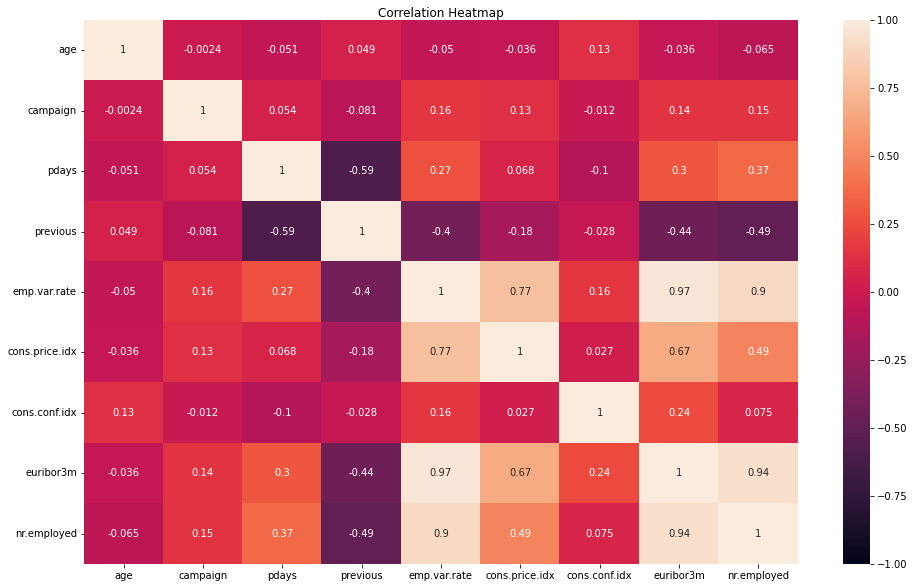

In [13]:
# corr plot to viz any correlations 
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(bank_data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=1);

### Modeling - classification model with CatBoost

In [14]:
"""
the dataset is a mix of numeric, categorical and string values. The algo picked for this model is 
CatBoost. Gradient boosted decision tree which builds symmetrical trees and can handle string and categorical 
values (no need for one-hot encoding before inputting to model).
"""

bank_data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11,25,services,single,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
12,29,blue-collar,single,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
13,57,housemaid,divorced,basic.4y,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [15]:
# split dat to train and test set
y = bank_data['y']
x = bank_data.drop(columns='y')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

In [16]:
# review ratio of y/n for each split of train and test 
print(y_train.value_counts())
print("\n* * * * * * * * * * * * * * * * * * *\n")
print(y_test.value_counts())

no     23982
yes     3457
Name: y, dtype: int64

* * * * * * * * * * * * * * * * * * *

no     2647
yes     402
Name: y, dtype: int64


In [17]:
# train model. Use the default settings because of time and mmachine power (CatBoost default setting is powerful enough). 
model = CatBoostClassifier().fit(X_train, y_train, verbose = False, cat_features=[
        "age",
        "job", 
        "marital", 
        "education", 
        "default", 
        "housing", 
        "loan", 
        "contact", 
        "month", 
        "day_of_week", 
        "poutcome"])

In [18]:
# make score matrix with accuracy, precision and recall
# inspiration to code from: https://towardsdatascience.com/employees-attrition-how-catboost-and-shap-can-help-you-understand-it-814f9bfd7df4

print("TRAIN PERFORMANCE:\n")
confusion_matrix_train = confusion_matrix(y_train, model.predict(X_train))
confusion_matrix_train = pd.DataFrame(confusion_matrix_train,
                                      index=["Actual_No","Actual_Yes"],
                                      columns=["Predicted_No","Predicted_Yes"])

display(confusion_matrix_train)

recall_resignation_train = confusion_matrix_train.iloc[1,1] / confusion_matrix_train.iloc[1,:].sum()
precision_resignation_train = confusion_matrix_train.iloc[1,1] / confusion_matrix_train.iloc[:,1].sum()
print("Precision Train: {}".format(round(precision_resignation_train,3)))


print("Accuracy Score: {}".format(round(model.score(X_train,y_train),3)))
print("Recall Train: {}".format(round(recall_resignation_train,3)))
print("\n* * * * * * * * * * * * * * * * * * *\n")
print("TEST PERFORMANCE:\n")
confusion_matrix_test = confusion_matrix(y_test, model.predict(X_test))
confusion_matrix_test = pd.DataFrame(confusion_matrix_test,
                                     index=["Actual_No","Actual_Yes"],
                                     columns=["Predicted_No","Predicted_Yes"])

display(confusion_matrix_test)

recall_resignation_test = confusion_matrix_test.iloc[1,1] / confusion_matrix_test.iloc[1,:].sum()
precision_resignation_test = confusion_matrix_test.iloc[1,1] / confusion_matrix_test.iloc[:,1].sum()

print("Accuracy Score: test {}".format(round(model.score(X_test,y_test),3)))
print("Recall test: {}".format(round(recall_resignation_test,3)))
print("Precision test: {}".format(round(precision_resignation_test,3)))

TRAIN PERFORMANCE:



,Predicted_No,Predicted_Yes
Actual_No,23592,390
Actual_Yes,2295,1162


Precision Train: 0.749
Accuracy Score: 0.902
Recall Train: 0.336

* * * * * * * * * * * * * * * * * * *

TEST PERFORMANCE:



,Predicted_No,Predicted_Yes
Actual_No,2588,59
Actual_Yes,287,115


Accuracy Score: test 0.887
Recall test: 0.286
Precision test: 0.661


### XAI - SHAP 

In [19]:
# setup the shap variables 
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(x)

Global feature importance

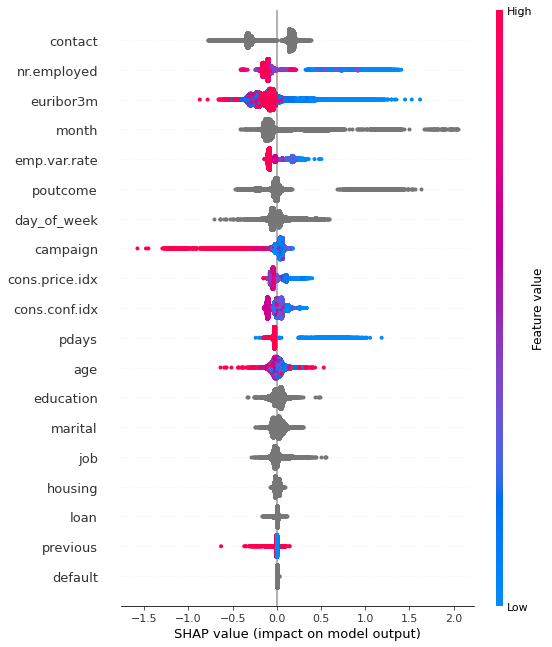

In [20]:
# Global summary of feature importance
shap.summary_plot(shap_values, x)

Feature importance for observation #4 &amp; #20

In [53]:
#observation #4
observation_4 = 4
index_choice_4 = bank_data.index.get_loc(observation_4)
x.iloc[index_choice_4]

age                        56
job                  services
marital               married
education         high.school
default                    no
housing                    no
loan                      yes
contact             telephone
month                     may
day_of_week               mon
campaign                    1
pdays                     999
previous                    0
poutcome          nonexistent
emp.var.rate              1.1
cons.price.idx         93.994
cons.conf.idx           -36.4
euribor3m               4.857
nr.employed            5191.0
Name: 4, dtype: object

In [54]:
# SHAP for #4
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[index_choice_4], x.iloc[index_choice_4])

In [51]:
#observation #20
observation_20 = 20
index_choice_20 = bank_data.index.get_loc(observation_20)
x.iloc[index_choice_20]

age                        30
job                unemployed
marital               married
education         high.school
default                    no
housing                    no
loan                       no
contact             telephone
month                     may
day_of_week               mon
campaign                    1
pdays                     999
previous                    0
poutcome          nonexistent
emp.var.rate              1.1
cons.price.idx         93.994
cons.conf.idx           -36.4
euribor3m               4.857
nr.employed            5191.0
Name: 20, dtype: object

In [52]:
# SHAP for #20
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values[index_choice_20], x.iloc[index_choice_20])